In [1]:
import csv
import os
from datetime import date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [2]:
# Output file for processed data
output_file = 'redacted_file.csv'
# Columns to keep in the new DataFrame
columns_to_keep = ['Date', 'HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A', 'LBH', 'LBD', 'LBA', 'FTR', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC']

# Folder path for CSV files
data_folder_path = r'C:\Users\marku\Documents\GitHub\Odds\data'


def process_csv_files(data_folder_path, output_file, columns_to_keep):

    with open(output_file, 'a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(columns_to_keep)  # Write column names at the top
        
        for filename in os.listdir(data_folder_path):
            if filename.endswith(".csv"):
                file_path = os.path.join(data_folder_path, filename)
                
                with open(file_path, 'r', encoding='utf-8', errors='replace') as csv_file:
                    csv_reader = csv.reader(csv_file)
                    header = next(csv_reader)  # Get the header
                    
                    # Identify the indices of the columns to keep
                    column_indices = [header.index(col) if col in header else None for col in columns_to_keep]
                    
                    for row in csv_reader:
                        # Handle missing values and replace invalid characters
                        for idx, value in enumerate(row):
                            if value == '�':
                                row[idx] = ''
  
                        # Select only the desired columns using identified indices
                        selected_row = [row[idx] if idx is not None else '' for idx in column_indices]
                        
                        # Handle missing values
                        for col_bet365, col_ladbrokes in zip(['B365H', 'B365D', 'B365A'], ['LBH', 'LBD', 'LBA']):
                            idx_bet365 = columns_to_keep.index(col_bet365)
                            idx_ladbrokes = columns_to_keep.index(col_ladbrokes)
                            
                            if selected_row[idx_bet365] == '':
                                selected_row[idx_bet365] = selected_row[idx_ladbrokes]
                       
                        # Append the selected row to the output file
                        writer.writerow(selected_row)

    print(f"Processed data saved to '{output_file}'.")

# Call the function to process CSV files
process_csv_files(data_folder_path, output_file, columns_to_keep)

df = pd.read_csv(output_file)

def process_csv_files2(df):
    # Remove LBH, LBD and LBA columns (not needed)
    df = df.drop(['LBH', 'LBD', 'LBA'], axis=1)

    # Create a column showing shot accuracy (shots on target / total shots, as percentage)
    df['HomeShotsAcc'] = (df['HST'] / df['HS']).astype(float).map("{:.2%}".format)

    # Shot accuracy for away team (as percentage)
    df['AwayShotsAcc'] = (df['AST'] / df['AS']).astype(float).map("{:.2%}".format)

    # Remove rows with missing values
    df = df.dropna()

    return df

df = process_csv_files2(df)

Processed data saved to 'redacted_file.csv'.


In [3]:
# Compute simple aggregates on the odds, goal difference, goal totals, shots, and shots on target for each team in the Premier League
def stats1 (df):
    print(df[['B365H']].describe())
    print('')
    print(df[['B365D']].describe())
    print('')
    print(df[['B365A']].describe())
    print('')
    return df
    
#stats1(df)

# Compute stats for each team in the Premier League
def stats2(df):
    # Group by 'HomeTeam' and calculate statistics
    home_team_stats = df.groupby('HomeTeam')[['B365H', 'B365D', 'B365A']].describe()
    
    # Group by 'AwayTeam' and calculate statistics
    away_team_stats = df.groupby('AwayTeam')[['B365H', 'B365D', 'B365A']].describe()
    
    # Return the stats
    df = home_team_stats, away_team_stats
    return df

#stats2(df)

# Compute rolling averages on performance metrics for each team in the Premier League over the past 5 matches
def stats3(df):
    # Compute rolling averages for home team performance metrics (shots, shots on target, goals, goal difference)
    df['HomeShotsRolling'] = df.groupby('HomeTeam', group_keys=False)['HS'].apply(lambda x: x.rolling(center=False, window=5).mean())
    df['HomeShotsOnTargetRolling'] = df.groupby('HomeTeam', group_keys=False)['HST'].apply(lambda x: x.rolling(center=False, window=5).mean())
    df['HomeGoalsRolling'] = df.groupby('HomeTeam', group_keys=False)['FTHG'].apply(lambda x: x.rolling(center=False, window=5).mean())
    
    # Compute rolling averages for away team performance metrics (shots, shots on target, goals, goal difference)
    df['AwayShotsRolling'] = df.groupby('AwayTeam', group_keys=False)['AS'].apply(lambda x: x.rolling(center=False, window=5).mean())
    df['AwayShotsOnTargetRolling'] = df.groupby('AwayTeam', group_keys=False)['AST'].apply(lambda x: x.rolling(center=False, window=5).mean())
    df['AwayGoalsRolling'] = df.groupby('AwayTeam', group_keys=False)['FTAG'].apply(lambda x: x.rolling(center=False, window=5).mean())
    
    # Drop missing values from Rolling columns
    df = df.dropna(subset=['HomeShotsRolling', 'HomeShotsOnTargetRolling', 'HomeGoalsRolling', 'AwayShotsRolling', 'AwayShotsOnTargetRolling', 'AwayGoalsRolling'])

    return df

df = stats3(df)

In [4]:
def format_dtypes(df):
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    min_date = df['Date'].min()
    df['Date'] = (df['Date'] - min_date).dt.days
    df['Date'] = df['Date'].astype('float64')
    
    # Convert HomeTeam and AwayTeam to category codes
    df['HomeTeamCode'] = df['HomeTeam'].astype('category').cat.codes
    df['AwayTeamCode'] = df['AwayTeam'].astype('category').cat.codes
    team_mapping = dict(enumerate(df['HomeTeam'].astype('category').cat.categories))
    
    # Convert FTR to category codes
    df['FTR'] = df['FTR'].astype('category').cat.codes

    # Convert numeric columns
    numerical_columns = ['B365H', 'B365D', 'B365A', 'FTHG', 'FTAG',
                         'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HomeShotsAcc',
                         'AwayShotsAcc', 'HomeShotsRolling', 'HomeShotsOnTargetRolling', 'HomeGoalsRolling',
                         'AwayShotsRolling', 'AwayShotsOnTargetRolling',
                         'AwayGoalsRolling']

    for col in numerical_columns:
        if df[col].dtype == 'object':
            # Handle columns with percentage signs
            if 'Acc' in col or 'Rate' in col:
                df[col] = df[col].str.replace('%', '').astype('float').fillna(0) / 100.0
            else:
                try:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                except ValueError:
                    print(f"Error converting column: {col}")
                    pass
        else:
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            except ValueError:
                print(f"Error converting column: {col}")
                pass
        
    # Convert HomeTeamCode and AwayTeamCode to float64 and FTR to float64
    df['HomeTeamCode'] = df['HomeTeamCode'].astype('float64')
    df['AwayTeamCode'] = df['AwayTeamCode'].astype('float64')
    df['FTR'] = df['FTR'].astype('float64')

    # Remove HomeTeam and AwayTeam columns
    df = df.drop(['HomeTeam', 'AwayTeam'], axis=1)
    
    return df, team_mapping

# Call the format_dtypes function to get the modified DataFrame and team_mapping dictionary
df, team_mapping = format_dtypes(df)

df.to_csv('test.csv', index=False)

# Print the team_mapping dictionary
print("Team Mapping:")
for code, team in team_mapping.items():
    print(f"Code: {code}, Team: {team}")

# Print FTR encodings
print("FTR encodings: ", df.FTR.unique())

# Print their mappings to original values
print("FTR mappings: ", df.FTR.map({0: 'A', 1: 'D', 2: 'H'}).unique())

# Save as a csv file called team_mapping.csv
pd.DataFrame.from_dict(team_mapping, orient='index').to_csv('team_mapping.csv', header=False)

Team Mapping:
Code: 0, Team: Arsenal
Code: 1, Team: Aston Villa
Code: 2, Team: Birmingham
Code: 3, Team: Blackburn
Code: 4, Team: Blackpool
Code: 5, Team: Bolton
Code: 6, Team: Bournemouth
Code: 7, Team: Brentford
Code: 8, Team: Brighton
Code: 9, Team: Burnley
Code: 10, Team: Cardiff
Code: 11, Team: Charlton
Code: 12, Team: Chelsea
Code: 13, Team: Crystal Palace
Code: 14, Team: Derby
Code: 15, Team: Everton
Code: 16, Team: Fulham
Code: 17, Team: Huddersfield
Code: 18, Team: Hull
Code: 19, Team: Leeds
Code: 20, Team: Leicester
Code: 21, Team: Liverpool
Code: 22, Team: Man City
Code: 23, Team: Man United
Code: 24, Team: Middlesbrough
Code: 25, Team: Newcastle
Code: 26, Team: Norwich
Code: 27, Team: Nott'm Forest
Code: 28, Team: Portsmouth
Code: 29, Team: QPR
Code: 30, Team: Reading
Code: 31, Team: Sheffield United
Code: 32, Team: Southampton
Code: 33, Team: Stoke
Code: 34, Team: Sunderland
Code: 35, Team: Swansea
Code: 36, Team: Tottenham
Code: 37, Team: Watford
Code: 38, Team: West Brom

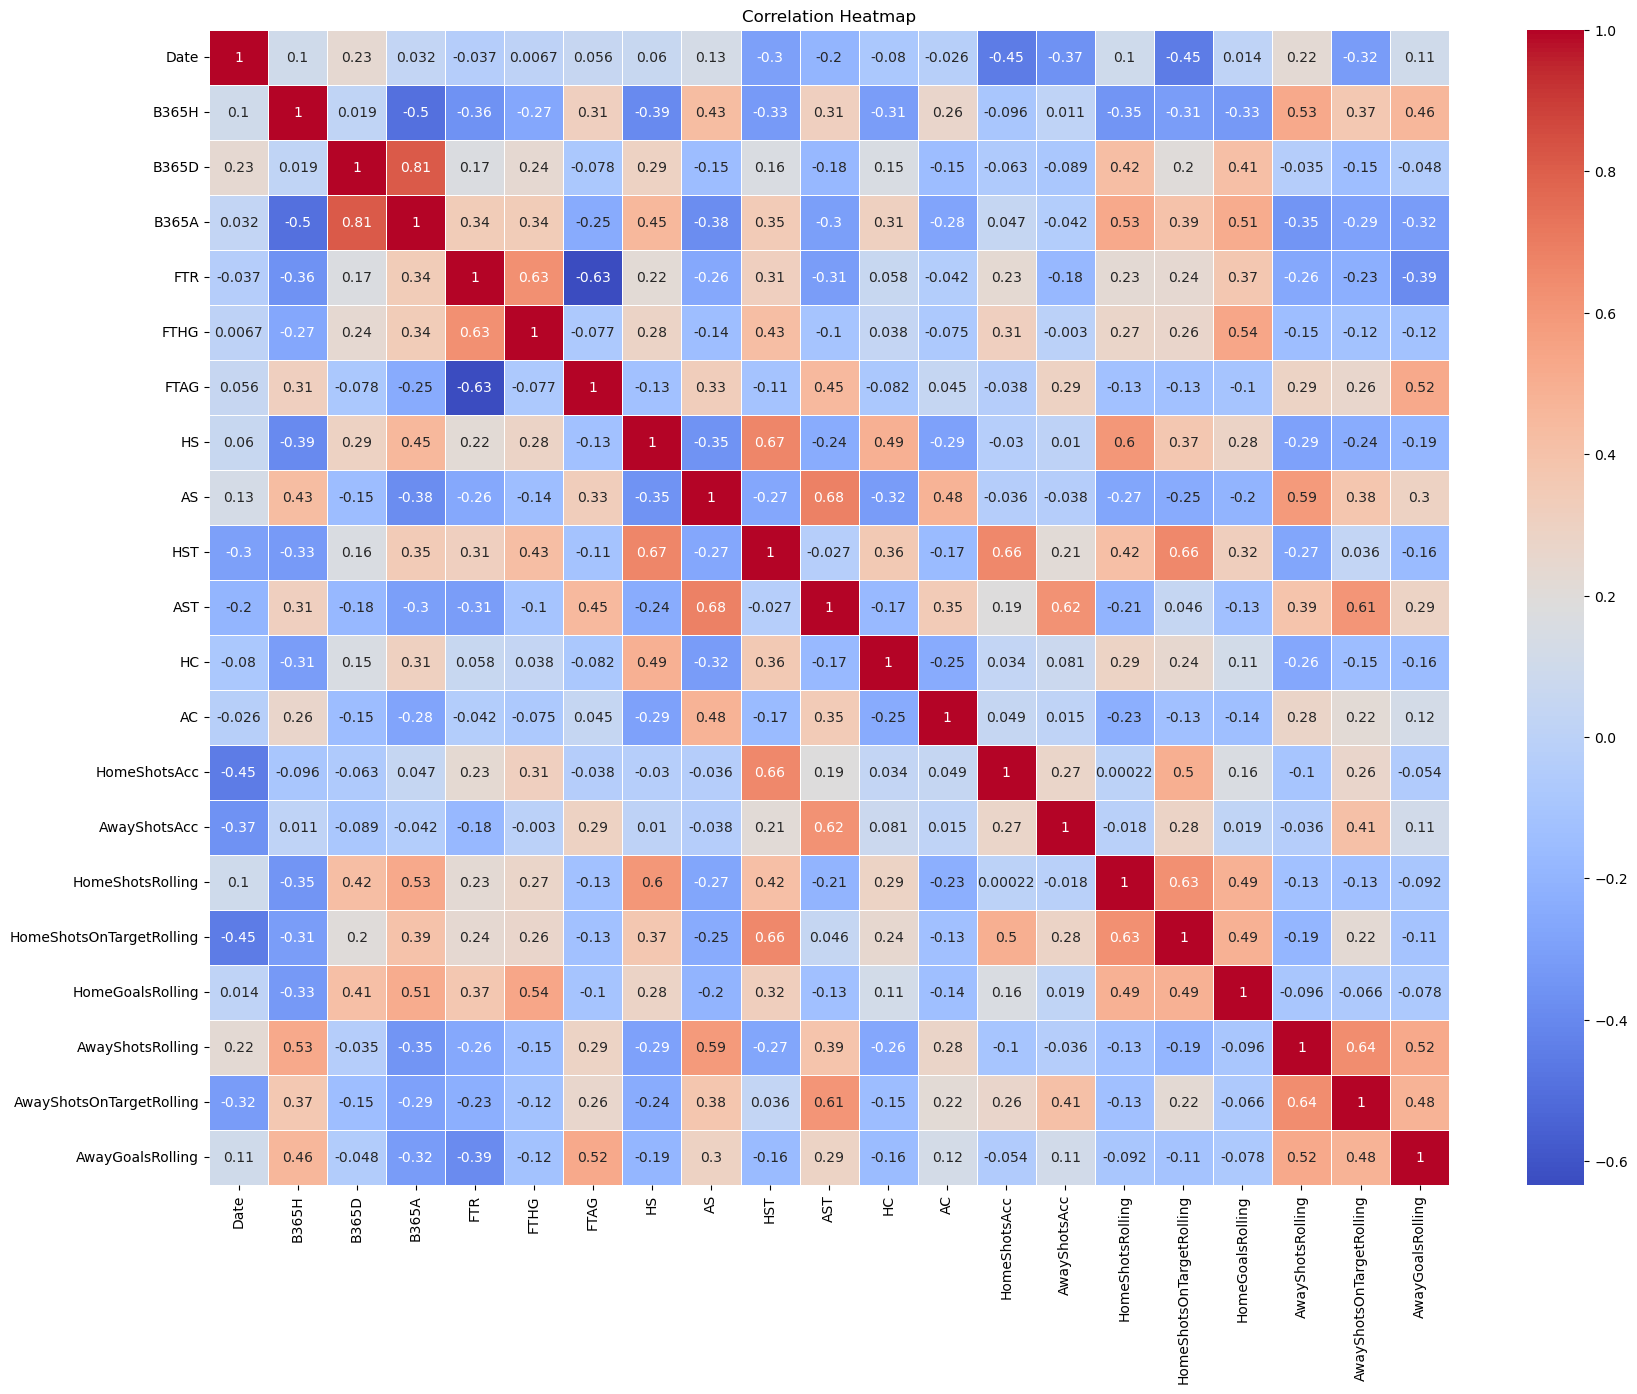

Top Correlations:
B365A         B365D    0.810422
B365D         B365A    0.810422
AS            AST      0.683691
AST           AS       0.683691
HST           HS       0.666491
                         ...   
HomeShotsAcc  Date    -0.453245
B365H         B365A   -0.495362
B365A         B365H   -0.495362
FTR           FTAG    -0.633348
FTAG          FTR     -0.633348
Length: 420, dtype: float64


In [5]:
def correlation_matrix(df):
    # Exclude columns that don't make sense for correlation matrix
    excluded_columns = ['HomeTeamCode', 'AwayTeamCode']
    
    # Select only numeric columns for correlation matrix
    numeric_columns = df.select_dtypes(include=['number']).columns
    valid_columns = [col for col in numeric_columns if col not in excluded_columns]
    correlation_matrix = df[valid_columns].corr()
    
    # Plot the correlation heatmap
    plt.figure(figsize=(20, 15))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
    plt.title("Correlation Heatmap")
    plt.show()
    
    # Create a list of coefficient pairs and sort in descending order
    correlations = correlation_matrix.unstack().sort_values(ascending=False)
    
    # Filter out pairs where both variables are the same or have a correlation of 1
    filtered_correlations = correlations[
        (correlations.index.get_level_values(0) != correlations.index.get_level_values(1)) &
        (correlations != 1.0)
    ]
    
    # Print the sorted list of coefficient pairs
    print("Top Correlations:")
    print(filtered_correlations)

correlation_matrix(df)

def pairplot2(df):
    sns.set(style="white")
    sns.pairplot(df, diag_kind="kde")
    plt.show()

# pairplot2(df)

In [6]:
# Features
X = df.drop(columns=['FTR', 'FTHG', 'FTAG'])

# Target variable
y = df['FTR']

# Splitting the data into train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

# Initialize Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit the model
clf.fit(X_train, y_train)

# Predict the results
y_pred = clf.predict(X_val)

# Print the accuracy
print("Accuracy:", accuracy_score(y_val, y_pred))

# Print classification report
print(classification_report(y_val, y_pred))

# Feature importance analysis
feature_importance = pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importance

Accuracy: 0.5984455958549223
              precision    recall  f1-score   support

         0.0       0.62      0.61      0.61       228
         1.0       0.32      0.18      0.23       184
         2.0       0.65      0.81      0.72       360

    accuracy                           0.60       772
   macro avg       0.53      0.53      0.52       772
weighted avg       0.56      0.60      0.57       772



,importance
HomeGoalsRolling,0.070510
B365H,0.067784
B365A,0.067382
AwayGoalsRolling,0.067105
HomeShotsAcc,0.065117
AwayShotsAcc,0.058115
Date,0.052974
HomeShotsRolling,0.049029
AwayShotsRolling,0.048901
HST,0.047464


In [7]:
# Predict on test set
y_pred = clf.predict(X_test)

# Print the accuracy from the testing data.
print("Accuracy: ", accuracy_score(y_test, y_pred))

# Classification report
print(classification_report(y_test, y_pred))

Accuracy:  0.628719275549806
              precision    recall  f1-score   support

         0.0       0.62      0.68      0.65       215
         1.0       0.34      0.17      0.23       178
         2.0       0.69      0.81      0.74       380

    accuracy                           0.63       773
   macro avg       0.55      0.56      0.54       773
weighted avg       0.59      0.63      0.60       773



0.6196636481241915
              precision    recall  f1-score   support

         0.0       0.58      0.68      0.63       215
         1.0       0.17      0.01      0.01       178
         2.0       0.64      0.87      0.74       380

    accuracy                           0.62       773
   macro avg       0.46      0.52      0.46       773
weighted avg       0.52      0.62      0.54       773



c:\Users\marku\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


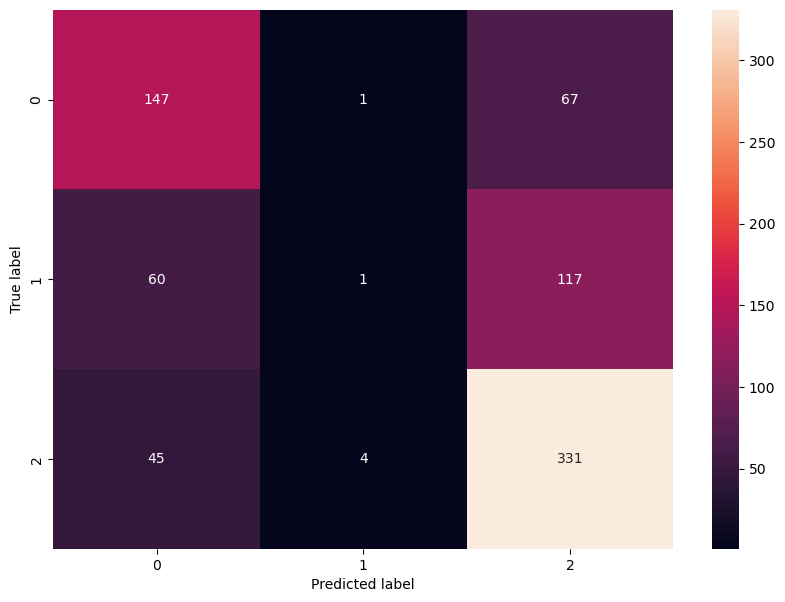

In [8]:
# Create a classifier
svm = LinearSVC(random_state=0, max_iter=10000)

# Train the classifier
svm.fit(X_train, y_train)

# Predict the outcome of a game
prediction = svm.predict(X_test)

# Print the accuracy score
print(accuracy_score(y_test, prediction))

# Print the classification report
print(classification_report(y_test, prediction))

# Compute confusion matrix
cm = confusion_matrix(y_test, prediction)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [9]:
# Create SVM classifier
svm_clf = SVC(kernel='linear', C=0.01, random_state=0)

# Fit classifier to training set
svm_clf.fit(X_train, y_train)

# Predict FTR for test set
y_pred = svm_clf.predict(X_test)

# Evaluate performance of classifier
print('Accuracy:', accuracy_score(y_test, y_pred))

# classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.648124191461837
              precision    recall  f1-score   support

         0.0       0.67      0.70      0.68       215
         1.0       0.34      0.15      0.20       178
         2.0       0.69      0.86      0.76       380

    accuracy                           0.65       773
   macro avg       0.57      0.57      0.55       773
weighted avg       0.60      0.65      0.61       773



In [10]:
# Create a Gradient Boosting Classifier
GB = GradientBoostingClassifier(n_estimators=2000, learning_rate=0.01, max_depth=1, random_state=0, loss='log_loss')

# Fit the model
GB.fit(X_train, y_train)

# Predict the model
y_pred = GB.predict(X_test)

# Print the accuracy score
print("Accuracy score:", accuracy_score(y_test, y_pred))

# Print classification report
print("Classification Report: \n {}\n".format(classification_report(y_test, y_pred)))

Accuracy score: 0.6494178525226391
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.65      0.69      0.67       215
         1.0       0.38      0.13      0.20       178
         2.0       0.69      0.87      0.77       380

    accuracy                           0.65       773
   macro avg       0.57      0.56      0.54       773
weighted avg       0.60      0.65      0.61       773


